# Analysis of 2019 Sales

## Data Wrangling & Cleansing

### Setup

In [76]:
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Collate source data

In [77]:
# import os

# df = pd.DataFrame()

# for file in os.listdir('./sales_data'):
#     month = pd.read_csv(f'./sales_data/{ file }', skip_blank_lines=True)
#     df = pd.concat([df, month], ignore_index=True, copy=False)
#     print(f'{file} { month.shape } => { df.shape }')

# df.tail()

### Remove superfluous header rows (interleaved in the data)

In [78]:
# df[df['Order ID'] == 'Order ID'].describe()

Attempting to drop headers via `read_csv()` above added columns. And as
there's `355` header rows within the data, I'm removing altogether here

In [79]:
# # Drop header rows
# df = df[df['Order ID'] != 'Order ID']

# df[df['Order ID'] == 'Order ID'].describe()

### Remove superfluous NaN rows

In [80]:
# df[df.isna().any(axis=1)].info()
# df[df.isna().any(axis=1)].tail()

`545` rows containing `NaN` (or equivalent) in `any` column

In [81]:
# # Drop NaN rows
# df = df[~df.isna().any(axis=1)]

# df[df.isna().any(axis=1)].info()

### Persist combined dataframe

In [82]:
# df.to_csv('2019-sales.cleaned.csv', index=False)

### Reload dataframe `df` from combined file

... with the added benefit that Pandas correctly identifies most column data types

In [83]:
df = pd.read_csv('2019-sales.cleaned.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order ID          185950 non-null  int64  
 1   Product           185950 non-null  object 
 2   Quantity Ordered  185950 non-null  int64  
 3   Price Each        185950 non-null  float64
 4   Order Date        185950 non-null  object 
 5   Purchase Address  185950 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 8.5+ MB


### Order Date => `datetime`

In [84]:
df['Order Date']

0         04/19/19 08:46
1         04/07/19 22:30
2         04/12/19 14:38
3         04/12/19 14:38
4         04/30/19 09:27
               ...      
185945    09/17/19 20:56
185946    09/01/19 16:00
185947    09/23/19 07:39
185948    09/19/19 17:30
185949    09/30/19 00:18
Name: Order Date, Length: 185950, dtype: object

In [85]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y %H:%M')
df.sort_values(by='Order Date', inplace=True)
df['Order Date']

73538   2019-01-01 03:07:00
74345   2019-01-01 03:40:00
75692   2019-01-01 04:56:00
76343   2019-01-01 05:53:00
75699   2019-01-01 06:03:00
                ...        
39113   2020-01-01 04:13:00
33863   2020-01-01 04:21:00
40860   2020-01-01 04:54:00
35322   2020-01-01 05:13:00
35323   2020-01-01 05:13:00
Name: Order Date, Length: 185950, dtype: datetime64[ns]

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 73538 to 35323
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int64         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.9+ MB


## Data Elaboration

In [87]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
73538,147268,Wired Headphones,1,11.99,2019-01-01 03:07:00,"9 Lake St, New York City, NY 10001"
74345,148041,USB-C Charging Cable,1,11.95,2019-01-01 03:40:00,"760 Church St, San Francisco, CA 94016"
75692,149343,Apple Airpods Headphones,1,150.00,2019-01-01 04:56:00,"735 5th St, New York City, NY 10001"
76343,149964,AAA Batteries (4-pack),1,2.99,2019-01-01 05:53:00,"75 Jackson St, Dallas, TX 75001"
75699,149350,USB-C Charging Cable,2,11.95,2019-01-01 06:03:00,"943 2nd St, Atlanta, GA 30301"


### Line Total

In [88]:
df['Line Total'] = df['Quantity Ordered'] * df['Price Each']

### Order Date

In [89]:
import calendar

# months = [calendar.month(2019, 1 + month) for month in range(12)]
# print(''.join(months))

months = [calendar.monthcalendar(2019, 1 + month) for month in range(12)]

def week_of_month(month = 1, day = 1):
    # print(months[month - 1])
    for idx, week in enumerate(months[month - 1]):
        if day in week:
            return idx + 1


df['At_Quarter_Change'] = (df['Order Date'].dt.is_quarter_start | df['Order Date'].dt.is_quarter_end)
df['Quarter'] = df['Order Date'].dt.quarter
df['At_Month_Change'] = (df['Order Date'].dt.is_month_start | df['Order Date'].dt.is_month_end)
df['ordinal_Month'] = df['Order Date'].dt.month
df['Month'] = df['Order Date'].dt.month_name()
df['ordinal_Day'] = df['Order Date'].dt.day
df['Day'] = df['Order Date'].dt.day_name()
df['Week_Of_Month'] = df['Order Date'].apply(lambda r: week_of_month(r.month, r.day))

# Round >= 40 minutes to the next hour
#TODO https://blog.hubspot.com/website/pandas-if-else
df['Minute'] = df['Order Date'].dt.minute
df['Hour'] = df['Order Date'].dt.hour
df.loc[df['Minute'] >= 45, 'Hour'] = 1 + df['Hour']
df.loc[df['Hour'] >= 24, 'Hour'] = 0
df.drop('Minute', axis=1, inplace=True)

df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Line Total,At_Quarter_Change,Quarter,At_Month_Change,ordinal_Month,Month,ordinal_Day,Day,Week_Of_Month,Hour
73538,147268,Wired Headphones,1,11.99,2019-01-01 03:07:00,"9 Lake St, New York City, NY 10001",11.99,True,1,True,1,January,1,Tuesday,1,3
74345,148041,USB-C Charging Cable,1,11.95,2019-01-01 03:40:00,"760 Church St, San Francisco, CA 94016",11.95,True,1,True,1,January,1,Tuesday,1,3
75692,149343,Apple Airpods Headphones,1,150.00,2019-01-01 04:56:00,"735 5th St, New York City, NY 10001",150.00,True,1,True,1,January,1,Tuesday,1,5
76343,149964,AAA Batteries (4-pack),1,2.99,2019-01-01 05:53:00,"75 Jackson St, Dallas, TX 75001",2.99,True,1,True,1,January,1,Tuesday,1,6
75699,149350,USB-C Charging Cable,2,11.95,2019-01-01 06:03:00,"943 2nd St, Atlanta, GA 30301",23.90,True,1,True,1,January,1,Tuesday,1,6


### Address

In [90]:
#TODO https://stackoverflow.com/questions/39050539/how-to-add-multiple-columns-to-pandas-dataframe-in-one-assignment
#[x] FIXME Takes 1 - 5min!!! to execute

# def parse_address(address = ""):
#     city = ','.join(address.split(',')[1:])
#     city = (city[:-6]).strip()
#     return {
#         'city': city,
#         'state': city[-2:],
#     }

# Append multiple columns when parsing the `Purchase Address` column into `city` and `state`
# df = df.join(
#     df['Purchase Address'].apply(lambda r: pd.Series(parse_address(r)))
# )

In [91]:
# Takes 1.7 - 4.2 seconds!!
# Step 1: Split the Address into Street and rest
# `840 Highland St, Los Angeles, CA 90001` => ['840 Highland St', 'Los Angeles, CA 90001']
df[['Street','City_State_Zip']] = df['Purchase Address'].str.split(', ', n=1, expand=True)

# Step 2: Split the `[1]` (the rest) index above into City, State and Zip
# `Los Angeles, CA 90001` => ['Los Angeles, CA','90001']
df[['City','Zip']] = df['City_State_Zip'].str.rsplit(' ', n=1, expand=True)

# Step 3: Split the `[0]` (City) index above into city-only and State (`[1]`)
# `Los Angeles, CA` => [ _ , 'CA']
df['State'] = df['City'].str.rsplit(', ', expand=True)[1]

# Step 4: Drop superfluous Purchase Address and WIP columns
df.drop([
    'Purchase Address', 
    'Street', 
    'City_State_Zip', 
    'Zip'],
    axis=1,
    inplace=True)

df.tail()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Line Total,At_Quarter_Change,Quarter,At_Month_Change,ordinal_Month,Month,ordinal_Day,Day,Week_Of_Month,Hour,City,State
39113,304165,AAA Batteries (4-pack),1,2.99,2020-01-01 04:13:00,2.99,True,1,True,1,January,1,Wednesday,1,4,"Portland, OR",OR
33863,299125,USB-C Charging Cable,1,11.95,2020-01-01 04:21:00,11.95,True,1,True,1,January,1,Wednesday,1,4,"New York City, NY",NY
40860,305840,Bose SoundSport Headphones,1,99.99,2020-01-01 04:54:00,99.99,True,1,True,1,January,1,Wednesday,1,5,"San Francisco, CA",CA
35322,300519,Bose SoundSport Headphones,1,99.99,2020-01-01 05:13:00,99.99,True,1,True,1,January,1,Wednesday,1,5,"New York City, NY",NY
35323,300519,Lightning Charging Cable,1,14.95,2020-01-01 05:13:00,14.95,True,1,True,1,January,1,Wednesday,1,5,"New York City, NY",NY


### Categorical Features

In [92]:
#TODO https://pbpython.com/categorical-encoding.html
#TODO https://hyperskill.org/learn/step/32241

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 73538 to 35323
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Order ID           185950 non-null  int64         
 1   Product            185950 non-null  object        
 2   Quantity Ordered   185950 non-null  int64         
 3   Price Each         185950 non-null  float64       
 4   Order Date         185950 non-null  datetime64[ns]
 5   Line Total         185950 non-null  float64       
 6   At_Quarter_Change  185950 non-null  bool          
 7   Quarter            185950 non-null  int32         
 8   At_Month_Change    185950 non-null  bool          
 9   ordinal_Month      185950 non-null  int32         
 10  Month              185950 non-null  object        
 11  ordinal_Day        185950 non-null  int32         
 12  Day                185950 non-null  object        
 13  Week_Of_Month      185950 non-null  int64     

#### Product

In [93]:
factorised_Product = pd.factorize(df['Product'])
df['ordinal_Product'] = factorised_Product[0]

df[['ordinal_Product', 'Product']]

,ordinal_Product,Product
73538,0,Wired Headphones
74345,1,USB-C Charging Cable
75692,2,Apple Airpods Headphones
76343,3,AAA Batteries (4-pack)
75699,1,USB-C Charging Cable
...,...,...
39113,3,AAA Batteries (4-pack)
33863,1,USB-C Charging Cable
40860,12,Bose SoundSport Headphones
35322,12,Bose SoundSport Headphones


#### City

In [94]:
factorised_City = pd.factorize(df['City'])
df['ordinal_City'] = factorised_City[0]

df[['ordinal_City', 'City']]

,ordinal_City,City
73538,0,"New York City, NY"
74345,1,"San Francisco, CA"
75692,0,"New York City, NY"
76343,2,"Dallas, TX"
75699,3,"Atlanta, GA"
...,...,...
39113,7,"Portland, OR"
33863,0,"New York City, NY"
40860,1,"San Francisco, CA"
35322,0,"New York City, NY"


#### State

In [95]:
factorised_State = pd.factorize(df['State'])
df['ordinal_State'] = factorised_State[0]

df[['ordinal_State', 'State']]

,ordinal_State,State
73538,0,NY
74345,1,CA
75692,0,NY
76343,2,TX
75699,3,GA
...,...,...
39113,6,OR
33863,0,NY
40860,1,CA
35322,0,NY


## Data Exploration

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 73538 to 35323
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Order ID           185950 non-null  int64         
 1   Product            185950 non-null  object        
 2   Quantity Ordered   185950 non-null  int64         
 3   Price Each         185950 non-null  float64       
 4   Order Date         185950 non-null  datetime64[ns]
 5   Line Total         185950 non-null  float64       
 6   At_Quarter_Change  185950 non-null  bool          
 7   Quarter            185950 non-null  int32         
 8   At_Month_Change    185950 non-null  bool          
 9   ordinal_Month      185950 non-null  int32         
 10  Month              185950 non-null  object        
 11  ordinal_Day        185950 non-null  int32         
 12  Day                185950 non-null  object        
 13  Week_Of_Month      185950 non-null  int64     

### Correlation between features

In [97]:
correlation = df.drop([
    'Order Date',
    'Order ID',
    'Quantity Ordered',
    'Product', 
    'Price Each',
    'Line Total',
    'Month', 
    'Day', 
    'City', 
    'State'
    ], axis=1).corr()
correlation

,At_Quarter_Change,Quarter,At_Month_Change,ordinal_Month,ordinal_Day,Week_Of_Month,Hour,ordinal_Product,ordinal_City,ordinal_State
At_Quarter_Change,1.000000,0.001956,0.571416,0.001267,0.000679,0.018590,-0.003260,-0.000259,0.000207,-0.000135
Quarter,0.001956,1.000000,0.000558,0.971585,0.017388,0.062606,0.002072,-0.001291,-0.000859,0.002439
At_Month_Change,0.571416,0.000558,1.000000,-0.000332,-0.002436,-0.005454,0.000329,0.001140,-0.002624,0.000810
ordinal_Month,0.001267,0.971585,-0.000332,1.000000,0.016394,0.110052,0.003463,-0.000645,-0.000806,0.002453
ordinal_Day,0.000679,0.017388,-0.002436,0.016394,1.000000,0.949634,-0.002173,-0.001423,0.002549,-0.003113
Week_Of_Month,0.018590,0.062606,-0.005454,0.110052,0.949634,1.000000,-0.001517,-0.001951,0.003260,-0.002563
Hour,-0.003260,0.002072,0.000329,0.003463,-0.002173,-0.001517,1.000000,0.002756,0.000178,0.002954
ordinal_Product,-0.000259,-0.001291,0.001140,-0.000645,-0.001423,-0.001951,0.002756,1.000000,-0.002537,0.000941
ordinal_City,0.000207,-0.000859,-0.002624,-0.000806,0.002549,0.003260,0.000178,-0.002537,1.000000,0.574563
ordinal_State,-0.000135,0.002439,0.000810,0.002453,-0.003113,-0.002563,0.002954,0.000941,0.574563,1.000000


<Axes: >

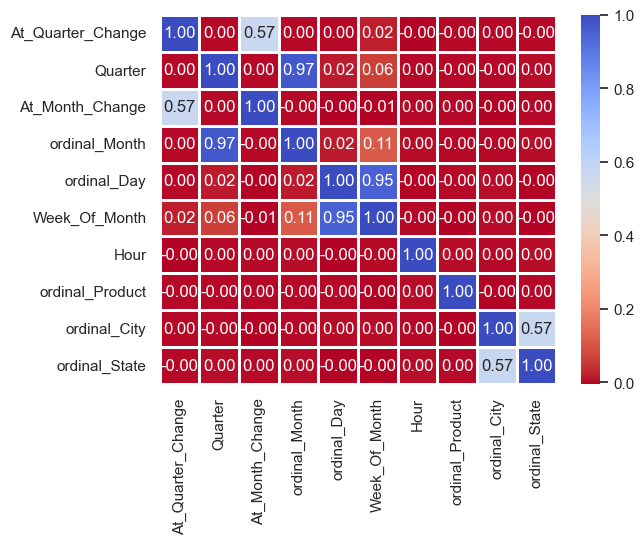

In [98]:
sns.heatmap(correlation, annot=True, linewidths=1, cmap='coolwarm_r', fmt="0.2f")

You would expect correlation between the features derived from `Order Date`, so this can be ignored. Similarly, features derived from the `Purchase Address` is expected to correlate, and can therefore be ignored as well.

However, the above heatmap also shows **no correlation between product, date, or location** -- which is atypical.

But as the products are electronic goods, it is reasonable to observe no seasonality or preference across locations. Sales spend may raise and fall over time, but not because a location or product is a driver.

In [99]:
#Drop features -- created in data elaboration -- that have no correlation, and are thus superfluous

df.drop([
    'At_Quarter_Change',
    'Quarter',
    'At_Month_Change',
    'ordinal_Day',
    'Day',
    'Week_Of_Month',
    'ordinal_Product',
    'ordinal_City',
    'ordinal_State'
    ], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 73538 to 35323
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int64         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Line Total        185950 non-null  float64       
 6   ordinal_Month     185950 non-null  int32         
 7   Month             185950 non-null  object        
 8   Hour              185950 non-null  int32         
 9   City              185950 non-null  object        
 10  State             185950 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2), object(4)
memory usage: 19.6+ MB


### Total Spend and Volume by Month

In [100]:
total_spend_and_volume_by_month = df \
    .groupby(['Month', 'ordinal_Month']) \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='ordinal_Month')

total_spend_and_volume_by_month.rename(columns={
    'Line Total': 'Total Spend (USD)',
    'Quantity Ordered': 'Total Volume'
    }, inplace=True)

total_spend_and_volume_by_month

,,Total Volume,Total Spend (USD)
Month,ordinal_Month,,
January,1,10903,1822256.73
February,2,13449,2202022.42
March,3,17005,2807100.38
April,4,20558,3390670.24
May,5,18667,3152606.75
June,6,15253,2577802.26
July,7,16072,2647775.76
August,8,13448,2244467.88
September,9,13109,2097560.13


### Total Spend and Volume by Hour

In [101]:
total_spend_and_volume_by_hour = df \
    .groupby('Hour') \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='Hour')
    
total_spend_and_volume_by_hour.rename(columns={
    'Line Total': 'Total Spend (USD)',
    'Quantity Ordered': 'Total Volume'
    }, inplace=True)

total_spend_and_volume_by_hour

,Total Volume,Total Spend (USD)
Hour,,
0,5104,833939.49
1,2921,505395.77
2,1693,289922.48
3,977,163482.43
4,872,139049.12
5,1289,209855.38
6,2393,371678.41
7,4066,669620.25
8,6300,1073258.34


### Total Spend and Volume by State and Product

In [102]:
total_spend_and_volume_by_state_and_product = df \
    .groupby(['State', 'Product']) \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='Line Total', ascending=False)

total_spend_and_volume_by_state_and_product.rename(columns={
    'Line Total': 'Total Spend (USD)',
    'Quantity Ordered': 'Total Volume'
    }, inplace=True)

total_spend_and_volume_by_state_and_product

Total Volume  Total Spend (USD)
State Product                                                  
CA    Macbook Pro Laptop                1887         3207900.00
      iPhone                            2779         1945300.00
      ThinkPad Laptop                   1604         1603983.96
      Google Phone                      2206         1323600.00
NY    Macbook Pro Laptop                 657         1116900.00
...                                      ...                ...
ME    Lightning Charging Cable           269            4021.55
      LG Dryer                             6            3600.00
      Wired Headphones                   279            3345.21
      AA Batteries (4-pack)              389            1493.76
      AAA Batteries (4-pack)             358            1070.42

[152 rows x 2 columns]

### Total Spend and Volume by City and Product

In [103]:
total_spend_and_volume_by_city_and_product = df \
    .groupby(['City', 'Product']) \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(['City', 'Line Total'], ascending=[True, False])

total_spend_and_volume_by_city_and_product.rename(columns={
    'Line Total': 'Total Spend (USD)',
    'Quantity Ordered': 'Total Volume'
    }, inplace=True)

total_spend_and_volume_by_city_and_product

#TODO Top 5 + rest
#https://stackoverflow.com/questions/20069009/pandas-get-topmost-n-records-within-each-group
#https://stackoverflow.com/questions/67720054/how-to-select-top-n-of-two-groups-and-aggregate-the-rest-of-the-second-group-int
#IDEA Compare city to city sales by spend on top 5 products to observe any anomalies (WA, ME?)

Total Volume  Total Spend (USD)
City        Product                                                  
Atlanta, GA Macbook Pro Laptop                 379          644300.00
            iPhone                             544          380800.00
            ThinkPad Laptop                    357          356996.43
            Google Phone                       451          270600.00
            27in 4K Gaming Monitor             493          192265.07
...                                            ...                ...
Seattle, WA Lightning Charging Cable          1775           26536.25
            USB-C Charging Cable              1869           22334.55
            Wired Headphones                  1652           19807.48
            AA Batteries (4-pack)             2179            8367.36
            AAA Batteries (4-pack)            2446            7313.54

[190 rows x 2 columns]

### Total Spend and Volume by Product

In [104]:
total_spend_and_volume_by_product = df \
    .groupby('Product') \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='Line Total', ascending=False)

total_spend_and_volume_by_product.rename(columns={
    'Line Total': 'Total Spend (USD)',
    'Quantity Ordered': 'Total Volume'
    }, inplace=True)

total_spend_and_volume_by_product

,Total Volume,Total Spend (USD)
Product,,
Macbook Pro Laptop,4728,8037600.00
iPhone,6849,4794300.00
ThinkPad Laptop,4130,4129958.70
Google Phone,5532,3319200.00
27in 4K Gaming Monitor,6244,2435097.56
34in Ultrawide Monitor,6199,2355558.01
Apple Airpods Headphones,15661,2349150.00
Flatscreen TV,4819,1445700.00
Bose SoundSport Headphones,13457,1345565.43


### Total Spend and Volume by Order

In [105]:
total_spend_and_volume_by_order = df \
    .groupby('Order ID') \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='Line Total', ascending=False)
    
total_spend_and_volume_by_order.rename(columns={
    'Line Total': 'Total Spend (USD)',
    'Quantity Ordered': 'Total Volume'
    }, inplace=True)

total_spend_and_volume_by_order.describe()

,Total Volume,Total Spend (USD)
count,178437.000000,178437.000000
mean,1.171724,193.300918
std,0.501673,341.274261
min,1.000000,2.990000
25%,1.000000,11.950000
50%,1.000000,14.950000
75%,1.000000,150.000000
max,9.000000,3779.990000


### Products most often bought together

In [106]:
products_by_order = df[ df['Order ID'].duplicated(keep=False) ] # keep all rows (don't collapse duplicates)

products_by_order['Products'] = products_by_order \
    .sort_values('Product') \
    .groupby('Order ID')['Product'] \
        .transform(lambda products: '|'.join(products))

products_by_order = products_by_order[ ['Order ID', 'Products'] ].drop_duplicates()

products_by_order

C:\Users\julrich\AppData\Local\Temp\ipykernel_13068\3747307962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_by_order['Products'] = products_by_order \


,Order ID,Products
70964,144804,Wired Headphones|iPhone
74381,148074,Google Phone|USB-C Charging Cable
74766,148450,Lightning Charging Cable|iPhone
70832,144679,Google Phone|USB-C Charging Cable
73729,147451,Google Phone|Wired Headphones
...,...,...
36679,301832,20in Monitor|AAA Batteries (4-pack)
46252,311036,AAA Batteries (4-pack)|Macbook Pro Laptop
46611,311386,Apple Airpods Headphones|iPhone
32501,297817,Lightning Charging Cable|iPhone


In [107]:
#TODO https://stackoverflow.com/questions/52195887/counting-unique-pairs-of-numbers-into-a-python-dictionary
from itertools import combinations
from collections import Counter

product_combinations = Counter()
for row in products_by_order['Products']:
    products = row.split('|')
    product_combinations.update(Counter(combinations(products, 2)))

product_combinations

Counter({('Lightning Charging Cable', 'iPhone'): 1015,
         ('Google Phone', 'USB-C Charging Cable'): 999,
         ('Wired Headphones', 'iPhone'): 462,
         ('Google Phone', 'Wired Headphones'): 423,
         ('Apple Airpods Headphones', 'iPhone'): 373,
         ('USB-C Charging Cable', 'Vareebadd Phone'): 368,
         ('Bose SoundSport Headphones', 'Google Phone'): 228,
         ('USB-C Charging Cable', 'Wired Headphones'): 205,
         ('Vareebadd Phone', 'Wired Headphones'): 149,
         ('Lightning Charging Cable', 'Wired Headphones'): 129,
         ('Apple Airpods Headphones', 'Lightning Charging Cable'): 116,
         ('AA Batteries (4-pack)', 'Lightning Charging Cable'): 106,
         ('Bose SoundSport Headphones', 'USB-C Charging Cable'): 102,
         ('Lightning Charging Cable', 'USB-C Charging Cable'): 100,
         ('Apple Airpods Headphones', 'Wired Headphones'): 100,
         ('AAA Batteries (4-pack)', 'USB-C Charging Cable'): 95,
         ('AA Batteries (4-pa

### Top Products

In [108]:
total_spend_and_volume_by_product

,Total Volume,Total Spend (USD)
Product,,
Macbook Pro Laptop,4728,8037600.00
iPhone,6849,4794300.00
ThinkPad Laptop,4130,4129958.70
Google Phone,5532,3319200.00
27in 4K Gaming Monitor,6244,2435097.56
34in Ultrawide Monitor,6199,2355558.01
Apple Airpods Headphones,15661,2349150.00
Flatscreen TV,4819,1445700.00
Bose SoundSport Headphones,13457,1345565.43


In [109]:
top_products_by_spend = total_spend_and_volume_by_product[:8]

top_products_by_spend

,Total Volume,Total Spend (USD)
Product,,
Macbook Pro Laptop,4728,8037600.00
iPhone,6849,4794300.00
ThinkPad Laptop,4130,4129958.70
Google Phone,5532,3319200.00
27in 4K Gaming Monitor,6244,2435097.56
34in Ultrawide Monitor,6199,2355558.01
Apple Airpods Headphones,15661,2349150.00
Flatscreen TV,4819,1445700.00


In [110]:

top_products_spend_and_volume = pd.DataFrame(
    total_spend_and_volume_by_product.sum(), 
    columns=['Total'])

top_products_spend_and_volume['Top'] = top_products_by_spend.sum()
top_products_spend_and_volume['Ratio'] = top_products_spend_and_volume['Top'] / top_products_spend_and_volume['Total']
top_products_spend_and_volume['Rest'] = 1 - top_products_spend_and_volume['Ratio']

top_products_spend_and_volume

,Total,Top,Ratio,Rest
Total Volume,209079.00,54162.00,0.259050,0.740950
Total Spend (USD),34492035.97,28866564.27,0.836905,0.163095


### Top Products Total Spend and Volume by Month

In [111]:
top_products_total_spend_and_volume_by_month = df[df['Product'].isin( list(top_products_by_spend.index) )] \
    .groupby(['Month', 'ordinal_Month', 'Product']) \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by=['ordinal_Month', 'Line Total'], ascending=[True, False])

top_products_total_spend_and_volume_by_month.rename(columns={
    'Line Total': 'Total Spend (USD)',
    'Quantity Ordered': 'Total Volume'
    }, inplace=True)

top_products_total_spend_and_volume_by_month

Total Volume  \
Month    ordinal_Month Product                                  
January  1             Macbook Pro Laptop                 235   
                       iPhone                             381   
                       ThinkPad Laptop                    219   
                       Google Phone                       319   
                       Apple Airpods Headphones           818   
...                                                       ...   
December 12            Google Phone                       715   
                       27in 4K Gaming Monitor             864   
                       34in Ultrawide Monitor             849   
                       Apple Airpods Headphones          2076   
                       Flatscreen TV                      666   

                                                 Total Spend (USD)  
Month    ordinal_Month Product                                      
January  1             Macbook Pro Laptop                399500.00  
                       iPhone                            266700.00  
                       ThinkPad Laptop                   218997.81  
                       Google Phone                      191400.00  
                       Apple Airpods Headphones          122700.00  
...                                                            ...  
December 12            Google Phone                      429000.00  
                       27in 4K Gaming Monitor            336951.36  
                       34in Ultrawide Monitor            322611.51  
                       Apple Airpods Headphones          311400.00  
                       Flatscreen TV                     199800.00  

[96 rows x 2 columns]

### Orders with Top Products

In [112]:
lines_with_top_products = df[df['Product'].isin( list(top_products_by_spend.index) )]

df['Top Product Order'] = df['Order ID'] \
    .isin( list(lines_with_top_products['Order ID'].unique()) )

orders_with_top_products = df.groupby('Top Product Order') \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='Line Total', ascending=False)
    
orders_with_top_products.rename(columns={
    'Line Total': 'Total Spend (USD)',
    'Quantity Ordered': 'Total Volume'
    }, inplace=True)

orders_with_top_products.set_index([pd.Index(['Top Products','Other Products'])], inplace=True)
orders_with_top_products = orders_with_top_products.T

orders_with_top_products['All Orders'] = orders_with_top_products['Top Products'] + orders_with_top_products['Other Products']
orders_with_top_products['Ratio'] = orders_with_top_products['Top Products'] / orders_with_top_products['All Orders']
orders_with_top_products['Rest'] = 1 - orders_with_top_products['Ratio']

orders_with_top_products

,Top Products,Other Products,All Orders,Ratio,Rest
Total Volume,59184.00,149895.00,209079.00,0.283070,0.716930
Total Spend (USD),28993747.74,5498288.23,34492035.97,0.840593,0.159407


## Analysis

In [113]:
sns.set_theme() # context='notepad', style='darkgrid', palette='dark'
highlight = 'purple'

### Best month for Sales by Spend

In [114]:
total_spend_and_volume_by_month

,,Total Volume,Total Spend (USD)
Month,ordinal_Month,,
January,1,10903,1822256.73
February,2,13449,2202022.42
March,3,17005,2807100.38
April,4,20558,3390670.24
May,5,18667,3152606.75
June,6,15253,2577802.26
July,7,16072,2647775.76
August,8,13448,2244467.88
September,9,13109,2097560.13


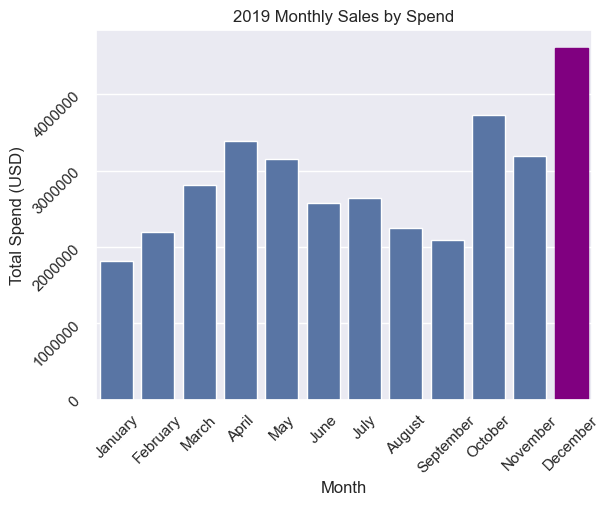

In [115]:
ax = sns.barplot(total_spend_and_volume_by_month, 
                 x='Month',
                 y='Total Spend (USD)',
                 )

for bar in ax.patches:
    if bar.get_height() == total_spend_and_volume_by_month['Total Spend (USD)'].max():
        bar.set_color(highlight)

ax.set(title='2019 Monthly Sales by Spend')
ax.tick_params(axis='both', labelrotation=45)
ax.ticklabel_format(axis='y', style='plain')
# ax.bar_label(ax.containers[0], fontsize=6)

#IDEA Add Volume on 2nd Y axis

### Sales over a day by Volume

In [116]:
total_spend_and_volume_by_hour

,Total Volume,Total Spend (USD)
Hour,,
0,5104,833939.49
1,2921,505395.77
2,1693,289922.48
3,977,163482.43
4,872,139049.12
5,1289,209855.38
6,2393,371678.41
7,4066,669620.25
8,6300,1073258.34


**NOTE:**
1.  Order times are assumed relevant as "local time"; no timezone adjustment was applied despite cities spanning the USA
1.  Where sales complete within 15min of the hour (inclusive), the sale is attributed to the following hour. For example, 23:45 is counted as 0, not 23. But 23:32 is counted as 23.

Text(0.5, 1.0, '2019 Sales over a day')

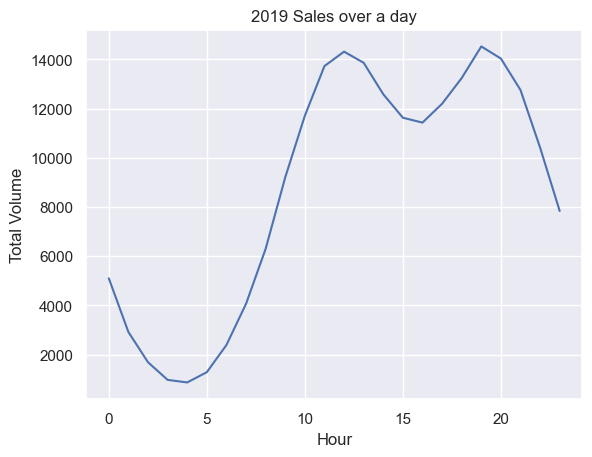

In [117]:
ax = sns.lineplot(total_spend_and_volume_by_hour,
                  x='Hour',
                  y='Total Volume',
                  )
ax.set_title('2019 Sales over a day')

### Best product by Volume

In [118]:
total_spend_and_volume_by_product.sort_values('Total Volume', ascending=False)

,Total Volume,Total Spend (USD)
Product,,
AAA Batteries (4-pack),31017,92740.83
AA Batteries (4-pack),27635,106118.40
USB-C Charging Cable,23975,286501.25
Lightning Charging Cable,23217,347094.15
Wired Headphones,20557,246478.43
Apple Airpods Headphones,15661,2349150.00
Bose SoundSport Headphones,13457,1345565.43
27in FHD Monitor,7550,1132424.50
iPhone,6849,4794300.00


Text(0.5, 1.0, '2019 Product Sales by Volume')

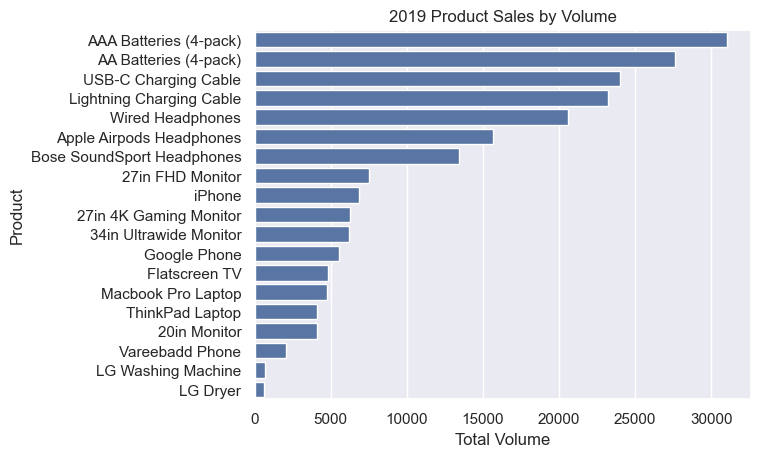

In [119]:
ax = sns.barplot(
    total_spend_and_volume_by_product.sort_values('Total Volume', ascending=False),
    x='Total Volume',
    y='Product',
)
ax.set_title('2019 Product Sales by Volume')

### Best products by Spend

In [120]:
total_spend_and_volume_by_product

,Total Volume,Total Spend (USD)
Product,,
Macbook Pro Laptop,4728,8037600.00
iPhone,6849,4794300.00
ThinkPad Laptop,4130,4129958.70
Google Phone,5532,3319200.00
27in 4K Gaming Monitor,6244,2435097.56
34in Ultrawide Monitor,6199,2355558.01
Apple Airpods Headphones,15661,2349150.00
Flatscreen TV,4819,1445700.00
Bose SoundSport Headphones,13457,1345565.43


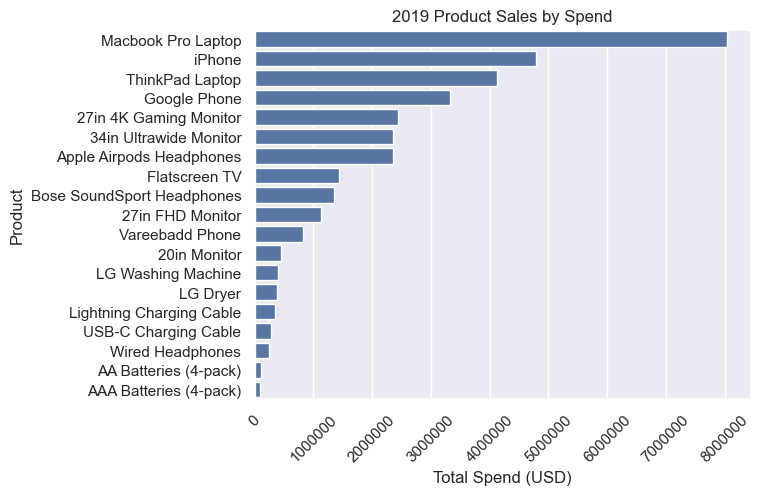

In [121]:
ax = sns.barplot(total_spend_and_volume_by_product,
                 x='Total Spend (USD)',
                 y='Product',
                 )
ax.set_title('2019 Product Sales by Spend')
ax.tick_params(axis='x', labelrotation=45)
ax.ticklabel_format(axis='x', style='plain')

### Products most often bought together

In [122]:
for combination in product_combinations.most_common(10):
    products = [product for product in combination[0]]
    products.sort(key=lambda s: len(s)) #HACK more valuable products have shorter names
    count = combination[1]
    print(' and '.join(products) + f' were sold together { count } times')


iPhone and Lightning Charging Cable were sold together 1015 times
Google Phone and USB-C Charging Cable were sold together 999 times
iPhone and Wired Headphones were sold together 462 times
Google Phone and Wired Headphones were sold together 423 times
iPhone and Apple Airpods Headphones were sold together 373 times
Vareebadd Phone and USB-C Charging Cable were sold together 368 times
Google Phone and Bose SoundSport Headphones were sold together 228 times
Wired Headphones and USB-C Charging Cable were sold together 205 times
Vareebadd Phone and Wired Headphones were sold together 149 times
Wired Headphones and Lightning Charging Cable were sold together 129 times


### Top products for >= 80% Sales by Spend

In [123]:
top_products_by_spend

,Total Volume,Total Spend (USD)
Product,,
Macbook Pro Laptop,4728,8037600.00
iPhone,6849,4794300.00
ThinkPad Laptop,4130,4129958.70
Google Phone,5532,3319200.00
27in 4K Gaming Monitor,6244,2435097.56
34in Ultrawide Monitor,6199,2355558.01
Apple Airpods Headphones,15661,2349150.00
Flatscreen TV,4819,1445700.00


In [124]:
top_products_spend_and_volume

,Total,Top,Ratio,Rest
Total Volume,209079.00,54162.00,0.259050,0.740950
Total Spend (USD),34492035.97,28866564.27,0.836905,0.163095


**NOTE:**
Focussing on the `Ratio` column, the `top_products_by_spend` products achieve `83.7%` of Spend by `25.9%` of sales Volume.

That is, `74%` of sales by Volume is from the remaining product catelogue (`Rest`), earning only `16.3%` of Spend (revenue).

In [125]:
pie_df = top_products_spend_and_volume.copy()
pie_df['Rest'] = pie_df['Total'] - pie_df['Top']
pie_df.drop(['Total','Ratio'], axis=1, inplace=True)

pie_df = pie_df.T
pie_df


,Total Volume,Total Spend (USD)
Top,54162.0,28866564.27
Rest,154917.0,5625471.70


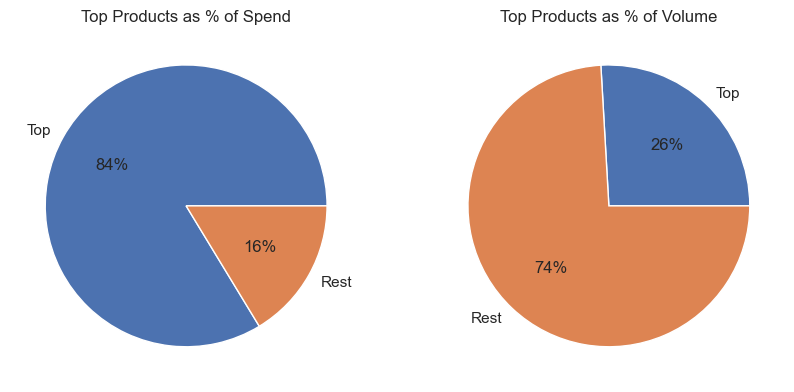

In [126]:
fig, (left,right) = plt.subplots(1, 2, figsize=(10,8))

left.pie(pie_df['Total Spend (USD)'],
        labels=pie_df.index,
        autopct='%.0f%%',
        )
left.set_title('Top Products as % of Spend')

right.pie(pie_df['Total Volume'],
          labels=pie_df.index,
          autopct='%.0f%%',
          )
right.set_title('Top Products as % of Volume')

plt.show()

### Top Products by State

In [127]:
#TODO Top Products by State
total_spend_and_volume_by_state_and_product

Total Volume  Total Spend (USD)
State Product                                                  
CA    Macbook Pro Laptop                1887         3207900.00
      iPhone                            2779         1945300.00
      ThinkPad Laptop                   1604         1603983.96
      Google Phone                      2206         1323600.00
NY    Macbook Pro Laptop                 657         1116900.00
...                                      ...                ...
ME    Lightning Charging Cable           269            4021.55
      LG Dryer                             6            3600.00
      Wired Headphones                   279            3345.21
      AA Batteries (4-pack)              389            1493.76
      AAA Batteries (4-pack)             358            1070.42

[152 rows x 2 columns]

### Top Products by Month

In [128]:
#TODO Top Products by Month

top_products_total_spend_and_volume_by_month

Total Volume  \
Month    ordinal_Month Product                                  
January  1             Macbook Pro Laptop                 235   
                       iPhone                             381   
                       ThinkPad Laptop                    219   
                       Google Phone                       319   
                       Apple Airpods Headphones           818   
...                                                       ...   
December 12            Google Phone                       715   
                       27in 4K Gaming Monitor             864   
                       34in Ultrawide Monitor             849   
                       Apple Airpods Headphones          2076   
                       Flatscreen TV                      666   

                                                 Total Spend (USD)  
Month    ordinal_Month Product                                      
January  1             Macbook Pro Laptop                399500.00  
                       iPhone                            266700.00  
                       ThinkPad Laptop                   218997.81  
                       Google Phone                      191400.00  
                       Apple Airpods Headphones          122700.00  
...                                                            ...  
December 12            Google Phone                      429000.00  
                       27in 4K Gaming Monitor            336951.36  
                       34in Ultrawide Monitor            322611.51  
                       Apple Airpods Headphones          311400.00  
                       Flatscreen TV                     199800.00  

[96 rows x 2 columns]

## Insight

### Product Catalogue

In [129]:
good_sellers = set()

# Top products by spend driving 80% of sales
for product in top_products_by_spend.index.values:
    good_sellers.add(product)

# Frequently bought together products
for combination in product_combinations.most_common(10):
    for product in combination[0]:
        good_sellers.add(product)

good_sellers

{'27in 4K Gaming Monitor',
 '34in Ultrawide Monitor',
 'Apple Airpods Headphones',
 'Bose SoundSport Headphones',
 'Flatscreen TV',
 'Google Phone',
 'Lightning Charging Cable',
 'Macbook Pro Laptop',
 'ThinkPad Laptop',
 'USB-C Charging Cable',
 'Vareebadd Phone',
 'Wired Headphones',
 'iPhone'}

In [130]:
total_spend_and_volume_by_product

,Total Volume,Total Spend (USD)
Product,,
Macbook Pro Laptop,4728,8037600.00
iPhone,6849,4794300.00
ThinkPad Laptop,4130,4129958.70
Google Phone,5532,3319200.00
27in 4K Gaming Monitor,6244,2435097.56
34in Ultrawide Monitor,6199,2355558.01
Apple Airpods Headphones,15661,2349150.00
Flatscreen TV,4819,1445700.00
Bose SoundSport Headphones,13457,1345565.43


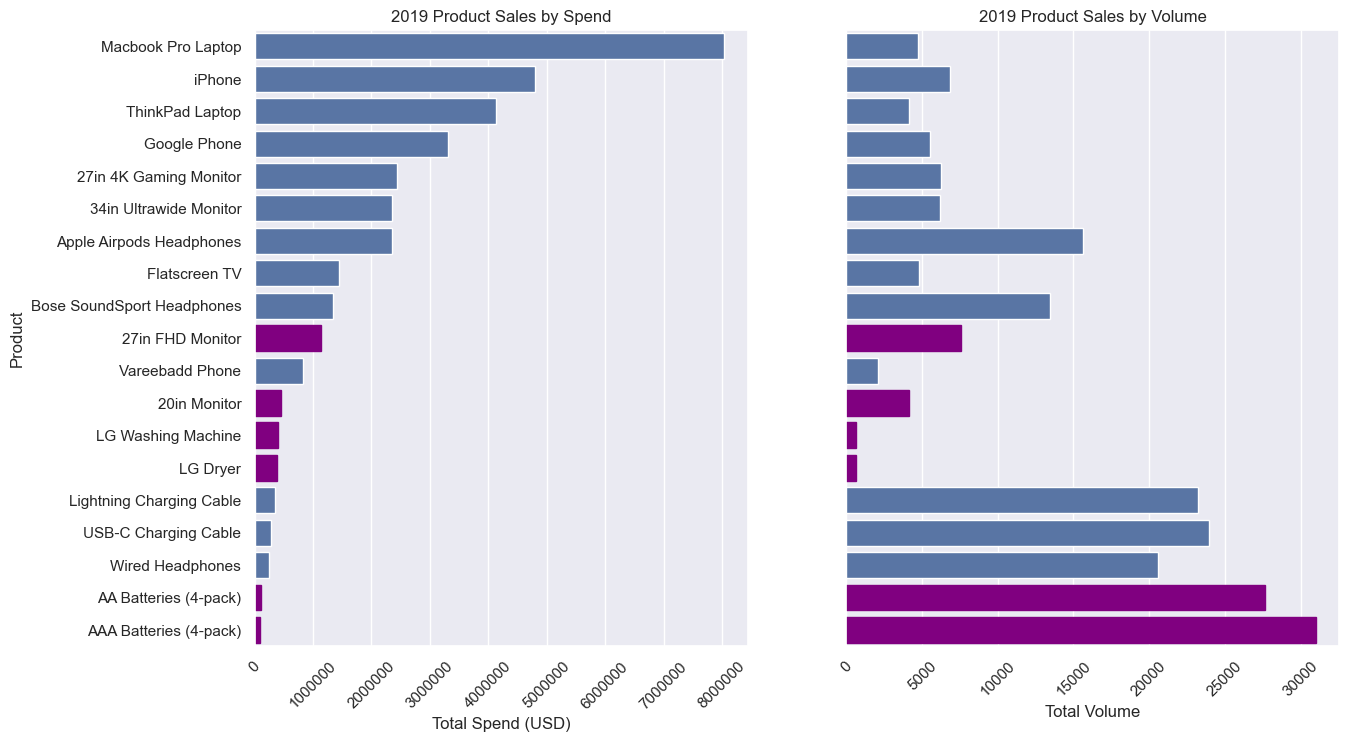

In [131]:
fig, (left,right) = plt.subplots(1, 2, 
                                 figsize=(14,8), 
                                 sharey=True
                                 )

sns.barplot(total_spend_and_volume_by_product, 
            x='Total Spend (USD)',
            y='Product',
            ax=left
            )
left.set_title('2019 Product Sales by Spend')
left.tick_params(axis='x', labelrotation=45)
left.ticklabel_format(axis='x', style='plain')


sns.barplot(total_spend_and_volume_by_product, 
            x='Total Volume',
            y='Product',
            ax=right
            )
right.set_title('2019 Product Sales by Volume')
right.tick_params(axis='x', labelrotation=45)

for idx, tick in enumerate(left.get_yticklabels()):
    if tick.get_text() not in good_sellers:
        # print(idx, ' ', tick.get_text())
        left.patches[idx].set_color(highlight)
        right.patches[idx].set_color(highlight)

In [132]:
#IDEA EDRT? of accumulated sales spend by product (descending)

#TODO Interpretation / suggestion

### Regional and City variance

In [133]:
#TODO Interpretation / suggestion